In [106]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [107]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [108]:
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
np.random.seed(0)

In [109]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.backends.cudnn.deterministic = True

In [110]:
if not os.path.exists("/content/trafic_32/"):
  !unzip gdrive/MyDrive/SSNE/proj5/trafic_32.zip

In [111]:
import torch.utils.data as data

dataFol = torchvision.datasets.ImageFolder(root="trafic_32")

train_set_size = int(len(dataFol) * 0.8)
test_set_size = len(dataFol) - train_set_size

train_set, test_set = data.random_split(dataFol, [train_set_size, test_set_size])

In [112]:
numOfClasses = len(dataFol.classes)

In [113]:
test_set.dataset.transform = transforms.Compose([
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])


train_set.dataset.transform = transforms.Compose([
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])


In [114]:
batch_size=256

g = torch.Generator()
g.manual_seed(0)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2, generator=g,)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2, generator=g,)

In [115]:
from torch.nn.modules.activation import ReLU
class Encoder(nn.Module):
    def __init__(self,
                 first_out_channels : int,
                 hidden_dim : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        super(Encoder, self).__init__()
        c_hid = first_out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(3, c_hid, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(2*c_hid),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*c_hid),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(2*c_hid),
            act_fn(),
            nn.Flatten(),
        )

        self.linear = nn.Sequential (
           nn.Linear(2*c_hid * 4 ** 2 + numOfClasses, hidden_dim),
           nn.BatchNorm1d(hidden_dim),
           nn.LeakyReLU(0.2),

           nn.Linear(hidden_dim, hidden_dim),
           nn.BatchNorm1d(hidden_dim),
           nn.LeakyReLU(0.2),
        )

        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var  = nn.Linear(hidden_dim, latent_dim)

        self.training = True

    def forward(self, x, one_hot):
        x = self.conv(x)
        x = torch.cat([x,one_hot], 1)
        x = self.linear(x)

        mean    = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean, log_var

In [116]:
class Decoder(nn.Module):
    def __init__(self,
                 first_input_channels : int,
                 hidden_dim : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        super(Decoder, self).__init__()
        c_hid = first_input_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim + numOfClasses, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, c_hid*2 * 4 ** 2),
            nn.BatchNorm1d(c_hid*2 * 4 ** 2),
            nn.LeakyReLU(0.2),
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.BatchNorm2d(2*c_hid),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*c_hid),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.ConvTranspose2d(c_hid, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Sigmoid(),
        )
        
    def forward(self, x, one_hot):
        x = torch.cat([x,one_hot], 1)

        x = self.linear(x)
        x = x.view(x.shape[0], -1, 4, 4)
        x = self.conv(x)
        return x
        

In [117]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(first_out_channels=input_dim, 
                               hidden_dim=hidden_dim, 
                               latent_dim=latent_dim, 
                               act_fn=nn.GELU)
        self.decoder = Decoder(latent_dim=latent_dim, 
                               hidden_dim = hidden_dim, 
                               first_input_channels = input_dim, 
                               act_fn=nn.GELU)

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)   # sampling epsilon        
        z = mean + var * epsilon                     # reparameterization trick
        return z    
                
    def forward(self, x, one_hot):
        mean, log_var = self.encoder(x, one_hot)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decoder(z, one_hot)
        return x_hat, mean, log_var

In [118]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [119]:
vae = VAE(latent_dim=100, hidden_dim=512, input_dim=50).to(device)

In [120]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

##Trening

In [121]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, label in trainloader:
        x = x.to(device)
        label = F.one_hot(label, num_classes=numOfClasses).to(device).float()

        out, means, log_var = vae(x, label)
        loss = vae_loss_function(x, out, means, log_var)  
        losses_epoch.append(loss.item())
        loss.backward()        # backward pass (compute parameter updates)
        optimizer.step()       # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    for x, label in iter(testloader):
        x  = x.to(device)
        label = F.one_hot(label, num_classes=numOfClasses).to(device).float()
        out, _, _ = vae(x, label)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n+1:02} loss {np.mean(np.array(losses_epoch)):.0f}, test L1 = {np.mean(L1_list):.4f}")
    scheduler.step()

Epoch 01 loss 32555, test L1 = 0.1102
Epoch 02 loss 20312, test L1 = 0.0976
Epoch 03 loss 17713, test L1 = 0.0921
Epoch 04 loss 16195, test L1 = 0.0868
Epoch 05 loss 15255, test L1 = 0.0848
Epoch 06 loss 14733, test L1 = 0.0841
Epoch 07 loss 14307, test L1 = 0.0806
Epoch 08 loss 13944, test L1 = 0.0789
Epoch 09 loss 13645, test L1 = 0.0778
Epoch 10 loss 13427, test L1 = 0.0767
Epoch 11 loss 13317, test L1 = 0.0770
Epoch 12 loss 13111, test L1 = 0.0760
Epoch 13 loss 12959, test L1 = 0.0759
Epoch 14 loss 12847, test L1 = 0.0746
Epoch 15 loss 12710, test L1 = 0.0745
Epoch 16 loss 12588, test L1 = 0.0740
Epoch 17 loss 12450, test L1 = 0.0739
Epoch 18 loss 12288, test L1 = 0.0727
Epoch 19 loss 12325, test L1 = 0.0731
Epoch 20 loss 12115, test L1 = 0.0719
Epoch 21 loss 12105, test L1 = 0.0718
Epoch 22 loss 11955, test L1 = 0.0724
Epoch 23 loss 11918, test L1 = 0.0715
Epoch 24 loss 11826, test L1 = 0.0706
Epoch 25 loss 11747, test L1 = 0.0712
Epoch 26 loss 11640, test L1 = 0.0713
Epoch 27 los

In [122]:
def visualize_reconstructions(model, input_imgs, labels, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        y = F.one_hot(labels, numOfClasses).to(device).float()
        reconst_imgs, means, log_var = model(input_imgs.to(device), y)
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

###Rekonstrukcja zdjęć

In [123]:
def get_train_images(num):
    return (torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0), torch.tensor([test_set[i][1] for i in range(10,10+num)]))

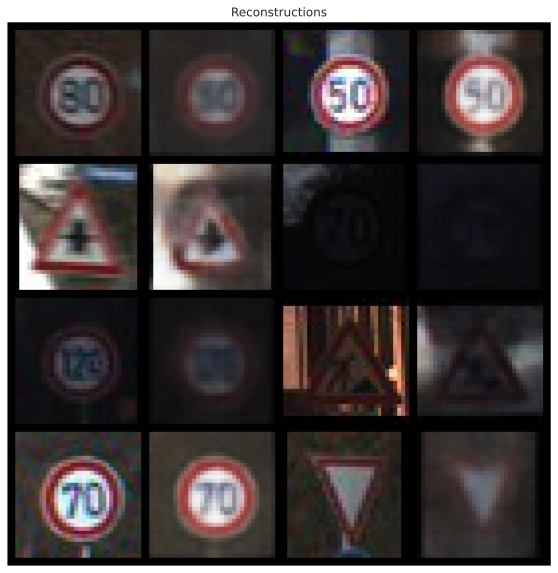

In [124]:
(input_imgs, labels) = get_train_images(8)
visualize_reconstructions(vae, input_imgs, labels, device)

In [125]:
def generate_images(model, n_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        rand_y = torch.randint(numOfClasses,(n_imgs,),device=device)
        rand_y = F.one_hot(rand_y, numOfClasses).float()
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device), rand_y)
    generated_imgs = generated_imgs.cpu()
    
    # Plotting
#     imgs = generated_imgs.flatten(0,1)
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

###Generacja nowych zdjęć

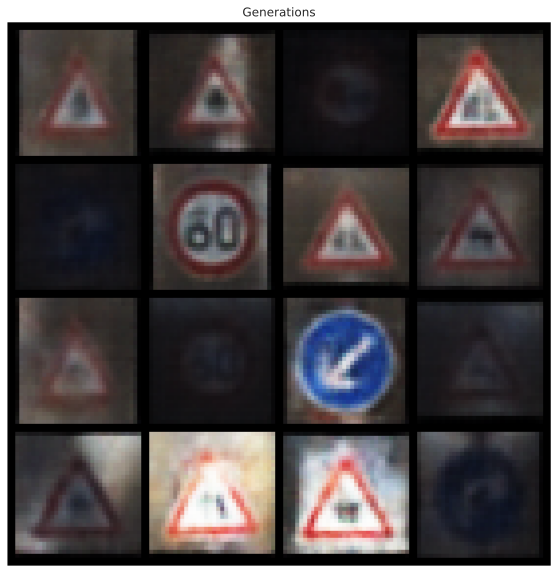

In [126]:
generate_images(vae, 16 , device)

##Ewaluacja danych

In [127]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 300)
        self.fc_out  = nn.Linear(300, numOfClasses)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)

In [128]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [129]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(trainloader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [130]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(testloader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print(f"Correctly guessed {num_correct/total_guesses*100:.2f}% of the dataset")

Correctly guessed 91.15% of the dataset


In [159]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, vae.latent_dim, device=device)
    fixed_labels = torch.randint(numOfClasses,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, numOfClasses).float()
    generations_vae = vae.decoder(fixed_noise, fixed_labels)

In [166]:
torch.save(generations_vae.cpu().detach(),"gdrive/MyDrive/SSNE/proj5/piatek_bielak_nitkiewicz.pt")

In [167]:
generations_vae.size()

torch.Size([1000, 3, 32, 32])

In [161]:
orig_data = []
for data, targets in iter(testloader):
    orig_data.append(data)
orig_data = torch.cat(orig_data)

In [162]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [163]:
#@title Code for Fid
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

##Obliczanie Fid

In [164]:
orig_data_2 = []
ite = iter(testloader)
for _ in range(4):
    data, _ = next(ite)
    orig_data_2.append(data)
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [165]:
for name, obj in zip(['orig','vae'],[dist_orig_data_2.numpy(),dist_vae.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: 10.263937668774815
FD vae: 77.33216138015996


##Best score:
* 88
* 84
* 86
* 79